# Download Daymet

In [1]:
%load_ext autoreload
%autoreload 2

Daymet provides gridded meteorological data for North American at 1km spatial resolution with daily timestep from 1980 ~ present. [website](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328) and [user guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| tmax | Daily maximum 2-meter air temperature (°C) |
| tmin | Daily minimum 2-meter air temperature (°C) |
| prcp | Daily total precipitation (mm/day) |
| srad | Incident shortwave radiation flux density (W/m2) |
| vp   | Water vapor pressure (Pa) |
| swe  | Snow water equivalent (kg/m2) |
| dayl | Duration of the daylight period (seconds) |

Notes:
 - The Daymet calendar is based on a standard calendar year. All Daymet years, including leap years, have 1 - 365 days. For leap years, the Daymet database includes leap day (February 29) and values for December 31 are discarded from leap years to maintain a 365-day year.
 
 - DayMet's incident shortwave radiation is the "daylit" radiation.  To get the daily average radiation, one must multiply by daylit fraction, given by dayl / 86400.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import logging
import numpy as np
import rasterio
import fiona
import os

import watershed_workflow
import watershed_workflow.ui
import watershed_workflow.daymet

watershed_workflow.ui.setup_logging(1,None)

In [4]:
watershed_shapefile = 'Coweeta/input_data/coweeta_basin.shp'

## import watershed

2021-11-19 12:22:05,145 - root - INFO: 
2021-11-19 12:22:05,146 - root - INFO: Loading shapes
2021-11-19 12:22:05,147 - root - INFO: ------------------------------
2021-11-19 12:22:05,148 - root - INFO: Loading file: 'Coweeta/input_data/coweeta_basin.shp'
2021-11-19 12:22:05,163 - root - INFO: ... found 1 shapes
2021-11-19 12:22:05,163 - root - INFO: Converting to shapely
2021-11-19 12:22:05,167 - root - INFO: crs: epsg:26917


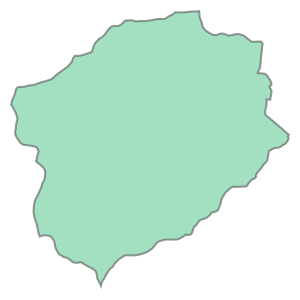

In [5]:
crs, watershed = watershed_workflow.get_split_form_shapes(watershed_shapefile)
logging.info(f'crs: {crs}')

bounds = watershed.exterior()
bounds

## Download

returned raw data has `dim(nband, ncol, nrow)`

In [6]:
startdate = "1-1980"
enddate = "365-1980"

In [7]:
# setting vars = None to download all available variables
raw, x, y = watershed_workflow.daymet.collectDaymet(bounds, crs=crs, 
                                                    start=startdate, end=enddate)

2021-11-19 12:22:05,269 - root - INFO: downloading variables: ['tmin', 'tmax', 'prcp', 'srad', 'vp', 'swe', 'dayl']
2021-11-19 12:22:05,274 - root - INFO: Collecting DayMet file to tile bounds: [-83.4885, 35.0173, -83.4117, 35.0838]
2021-11-19 12:22:05,275 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmin_1980_35.0838x-83.4885_35.0173x-83.4117.nc
2021-11-19 12:22:05,289 - root - INFO: Collecting DayMet file to tile bounds: [-83.4885, 35.0173, -83.4117, 35.0838]
2021-11-19 12:22:05,291 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmax_1980_35.0838x-83.4885_35.0173x-83.4117.nc
2021-11-19 12:22:05,304 - root - INFO: Collecting DayMet file to tile bounds: [-83.4885, 35.0173, -83.4117, 35.0838]
2021-11-19 12:22:05,305 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_prcp_1980_35.0838x-83.4885_35.0173x-83.4117.nc

## Reproject Daymet CRS

Reproject daymet CRS to the same as the watershed. This is necessary if watershed meshes are using watershed CRS.

In [8]:
new_x, new_y, new_extent, new_dat, daymet_profile = \
        watershed_workflow.daymet.reproj_Daymet(x, y, raw, dst_crs=crs)

/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_DEV-2021-11-10/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
2021-11-19 12:22:05,416 - root - INFO: reprojecting to new crs: epsg:26917
2021-11-19 12:22:05,637 - root - INFO: new profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 9, 'height': 9, 'count': 365, 'crs': CRS.from_epsg(26917), 'transform': Affine(1269.2471471714439, 0.0, 270906.5914069811,
       0.0, -1269.2471471714439, 3886667.329107363), 'tiled': False, 'interleave': 'pixel'}
2021-11-19 12:22:05,637 - root - INFO: new extent[xmin, ymin, xmax, ymax]: (270906.5914069811, 3875244.1047828197, 282329.8157315241, 3886667.329107363)


## plot Daymet

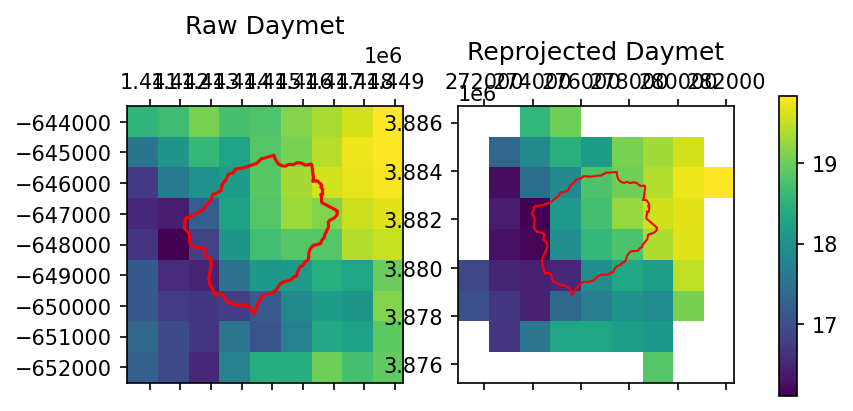

In [9]:
ivar = 'tmax'
islice = 100
fig, axes = plt.subplots(1, 2)

ax = axes[0]
extent = rasterio.transform.array_bounds(daymet_profile['height'], daymet_profile['width'], daymet_profile['transform']) # (x0, y0, x1, y1)
plot_extent = extent[0], extent[2], extent[1], extent[3]

iraster = raw[ivar][islice, :, :]

with fiona.open(watershed_shapefile, mode='r') as fid:
    bnd_profile = fid.profile
    bnd = [r for (i,r) in fid.items()]
daymet_crs = watershed_workflow.crs.daymet_crs()

# convert to destination crs
native_crs = watershed_workflow.crs.from_fiona(bnd_profile['crs'])
reproj_bnd = watershed_workflow.warp.shape(bnd[0], native_crs, daymet_crs)
reproj_bnd_shply = watershed_workflow.utils.shply(reproj_bnd)

cax = ax.matshow(iraster, extent=plot_extent, alpha=1)
ax.plot(*reproj_bnd_shply.exterior.xy, 'r')
ax.set_title("Raw Daymet")


ax = axes[1]
extent = new_extent # (x0, y0, x1, y1)
plot_extent = extent[0], extent[2], extent[1], extent[3] # (x0, x1, y0, y1)

iraster = new_dat[ivar][islice, :, :]

# set nodata to NaN to avoid plotting
iraster[iraster == -9999] = np.nan

watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='r', linewidth=1)
im = ax.matshow(iraster, extent=plot_extent)
ax.set_title("Reprojected Daymet")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax)

# save daymet

## Write to HDF5

Write raw daymet data to a single HDF5 file.

In [10]:
watershed_workflow.daymet.writeHDF5(new_dat, new_x, new_y, 
                         watershed_workflow.daymet.getAttrs(bounds.bounds, startdate, enddate), 
                         os.path.join('Coweeta','output_data', 'watershed_daymet-raw.h5'))

2021-11-19 12:22:06,115 - root - INFO: Writing HDF5 file: Coweeta/output_data/watershed_daymet-raw.h5


## Write to ATS format

This will write daymet in a format that ATS can read. E.g., this will partition precipitation into rain and snow, convert vapor pressure to relative humidity, get mean air temperature and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

In [11]:
dat_ats = watershed_workflow.daymet.writeATS(new_dat, new_x, new_y, 
                         watershed_workflow.daymet.getAttrs(bounds.bounds, startdate, enddate), 
                         os.path.join('Coweeta', 'output_data', 'watershed_daymet-ats.h5'))

2021-11-19 12:22:06,868 - root - INFO: input dat shape: (365, 9, 9)
2021-11-19 12:22:06,869 - root - INFO: Converting to ATS met input
2021-11-19 12:22:06,872 - root - INFO: Writing ATS file: Coweeta/output_data/watershed_daymet-ats.h5
